In [1]:
import os
import numpy as np
import torch
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random
import time
import warnings
import math
import traceback
from einops import rearrange
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# =============================================
# 1. SETUP AND CONFIGURATION
# =============================================

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories
os.makedirs('checkpoints', exist_ok=True)

Using device: cuda


In [2]:
# =============================================
# 2. DATA LOADING AND EXPLORATION
# =============================================

# Load data

emotion_mapping = {
        "marah": 0, "jijik": 1, "takut": 2,
        "bahagia": 3, "netral": 4, "sedih": 5
    }

def load_data():
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    
   
    
    # Split into train/val
    train_data, val_data = train_test_split(
        train_df, test_size=0.15, random_state=42, stratify=train_df['label']
    )
    
    print(f"Training data: {len(train_data)} samples")
    print(f"Validation data: {len(val_data)} samples")
    print(f"Test data: {len(test_df)} samples")
    
    return train_df, test_df, train_data, val_data, emotion_mapping

# Analyze data distributions
def analyze_data_distribution(train_data, val_data, test_df):
    # Count the emotion distributions
    train_dist = train_data['label'].value_counts().sort_index()
    val_dist = val_data['label'].value_counts().sort_index()
    
    # Check if test data has labels
    if 'label' in test_df.columns:
        test_dist = test_df['label'].value_counts().sort_index()
        has_test_labels = True
    else:
        has_test_labels = False
    
    # Create visualizations
    plt.figure(figsize=(14, 8))
    
    # Training distribution
    ax1 = plt.subplot(1, 3, 1)
    sns.barplot(x=train_dist.index, y=train_dist.values, palette='viridis')
    plt.title('Training Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add count labels on the bars
    for i, count in enumerate(train_dist.values):
        plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

    # Validation distribution
    ax2 = plt.subplot(1, 3, 2)
    sns.barplot(x=val_dist.index, y=val_dist.values, palette='viridis')
    plt.title('Validation Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add count labels
    for i, count in enumerate(val_dist.values):
        plt.text(i, count + 1, str(count), ha='center', fontweight='bold')
    
    # Test distribution if available
    if has_test_labels:
        ax3 = plt.subplot(1, 3, 3)
        sns.barplot(x=test_dist.index, y=test_dist.values, palette='viridis')
        plt.title('Test Emotion Distribution')
        plt.xlabel('Emotion')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        for i, count in enumerate(test_dist.values):
            plt.text(i, count + 1, str(count), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Emotion Distribution:")
    print("\nTraining Dataset:")
    train_percent = (train_dist / train_dist.sum() * 100).round(2)
    for emotion, count in zip(train_dist.index, train_dist.values):
        print(f"{emotion}: {count} samples ({train_percent[emotion]}%)")
    
    print("\nValidation Dataset:")
    val_percent = (val_dist / val_dist.sum() * 100).round(2)
    for emotion, count in zip(val_dist.index, val_dist.values):
        print(f"{emotion}: {count} samples ({val_percent[emotion]}%)")
    
    # Create pie charts
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.pie(train_dist.values, labels=train_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Training Data Emotion Distribution')
    
    plt.subplot(1, 3, 2)
    plt.pie(val_dist.values, labels=val_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Validation Data Emotion Distribution')
    
    if has_test_labels:
        plt.subplot(1, 3, 3)
        plt.pie(test_dist.values, labels=test_dist.index, autopct='%1.1f%%', startangle=90, shadow=True)
        plt.title('Test Data Emotion Distribution')
    
    plt.tight_layout()
    plt.show()


In [3]:
# =============================================
# 3. DATASET CLASSES
# =============================================

class EmotionDataset(Dataset):
    def __init__(self, df, base_path, fast_mode=True, use_cache=True):
        self.df = df
        self.base_path = base_path
        self.class2idx = {"marah":0, "jijik":1, "takut":2, "bahagia":3, "netral":4, "sedih":5}
        self.fast_mode = fast_mode
        self.use_cache = use_cache
        self.cache = {}
        
        # Audio preprocessing settings
        self.target_sr = 16000
        self.target_duration = 2.5 if fast_mode else 3.0
        
        # Create mel spectrogram transform with improved settings
        if fast_mode:
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.target_sr,
                n_fft=512, n_mels=64, hop_length=256,
                f_min=20, f_max=8000
            )
        else:
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.target_sr,
                n_fft=1024, n_mels=80, hop_length=256,
                f_min=20, f_max=8000
            )
        
        # MFCC transform
        self.mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=self.target_sr,
            n_mfcc=13,
            melkwargs={
                'n_fft': 512,
                'n_mels': 40,
                'hop_length': 256
            }
        )
        
        # Chroma feature transform
        self.chroma_transform = torchaudio.transforms.Spectrogram(
            n_fft=512, 
            win_length=400,
            hop_length=160
        )

    def __len__(self):
        return len(self.df)
    
    # Helper methods for audio processing    
    def preemphasis(self, waveform, coef=0.97):
        """Apply pre-emphasis filter to highlight higher frequencies"""
        result = torch.zeros_like(waveform)
        result[:, 0] = waveform[:, 0]
        result[:, 1:] = waveform[:, 1:] - coef * waveform[:, :-1]
        return result
    
    def normalize_audio(self, waveform):
        """Normalize audio to have zero mean and unit variance"""
        if waveform.numel() > 0 and torch.std(waveform) > 0:
            return (waveform - torch.mean(waveform)) / (torch.std(waveform) + 1e-10)
        return waveform
        
    def vad_trim(self, waveform, top_db=30):
        """Trim silence from audio using Voice Activity Detection"""
        # Skip VAD for extremely short segments
        if waveform.size(1) < 100:
            return waveform
            
        # Get frame-wise energy
        window_size = 200
        energy = torch.square(waveform)
        window_energy = torch.nn.functional.avg_pool1d(
            energy, kernel_size=window_size, stride=1, padding=window_size//2
        )
        
        # Get threshold
        db_threshold = torch.max(window_energy) / (10**(top_db/10))
        
        # Find voiced frames
        voiced = (window_energy > db_threshold).squeeze()
        
        if torch.sum(voiced) < 100:  # If very few voiced frames found
            return waveform  # Return original
            
        # Find start/end of speech
        start = max(0, torch.where(voiced)[0][0] - window_size)
        end = min(waveform.size(1), torch.where(voiced)[0][-1] + window_size)
        
        return waveform[:, start:end]
        
    def compute_pitch_features(self, waveform, num_features=6):
        """Compute pitch-related features"""
        spec = self.chroma_transform(waveform)
        spec_dim = spec.shape[1]
        freqs = torch.linspace(0, self.target_sr/2, spec_dim)
        freqs = freqs.view(1, -1, 1).to(spec.device)
        
        # Spectral centroid
        centroid = torch.sum(freqs * spec, dim=1) / (torch.sum(spec, dim=1) + 1e-8)
        
        # Spectral flux
        if spec.shape[2] > 1:
            flux = torch.sqrt(torch.sum(torch.diff(spec, dim=2)**2, dim=1))
        else:
            flux = torch.zeros(spec.shape[0], 1).to(spec.device)
        
        # Frequency bands
        band_size = max(1, spec_dim // num_features)
        bands = []
        for i in range(num_features):
            start_idx = i * band_size
            end_idx = min((i + 1) * band_size, spec_dim)
            if start_idx < end_idx:
                band_energy = torch.mean(spec[:, start_idx:end_idx, :], dim=1)
                bands.append(band_energy)
            else:
                bands.append(torch.zeros(spec.shape[0], spec.shape[2]).to(spec.device))
            
        features = torch.stack(bands, dim=1)
        
        # Ensure right number of features
        if features.shape[1] < num_features:
            padding = torch.zeros(features.shape[0], 
                             num_features - features.shape[1], 
                             features.shape[2], 
                             device=features.device)
            features = torch.cat([features, padding], dim=1)
            
        return features
    
    

    def __getitem__(self, idx):
        # Get audio path and label
        row = self.df.iloc[idx]
        audio_id = row['id']
        audio_path = f"{self.base_path}/{audio_id}"
        
        # Use cache if available
        if self.use_cache and audio_path in self.cache:
            return self.cache[audio_path]
            
        try:
            # Load and process audio
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # Convert stereo to mono
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            
            # Resample if needed
            if sample_rate != self.target_sr:
                waveform = torchaudio.functional.resample(waveform, sample_rate, self.target_sr)
            
            # Process audio signal
            waveform = self.normalize_audio(waveform)
            waveform = self.preemphasis(waveform)
            waveform = self.vad_trim(waveform)
            
            # Ensure consistent length
            target_samples = int(self.target_sr * self.target_duration)
            if waveform.size(1) > target_samples:
                start = (waveform.size(1) - target_samples) // 2
                waveform = waveform[:, start:start + target_samples]
            else:
                padding_left = (target_samples - waveform.size(1)) // 2
                padding_right = target_samples - waveform.size(1) - padding_left
                
                # Select appropriate padding mode
                if padding_left >= waveform.size(1) or padding_right >= waveform.size(1):
                    if waveform.size(1) > 1:
                        waveform = torch.nn.functional.pad(waveform, (padding_left, padding_right), 
                                                          mode='replicate')
                    else:
                        waveform = torch.nn.functional.pad(waveform, (padding_left, padding_right), 
                                                          mode='constant', value=0)
                else:
                    waveform = torch.nn.functional.pad(waveform, (padding_left, padding_right), 
                                                      mode='reflect')
            
            # Extract features
            mel_specgram = self.mel_spec_transform(waveform)
            mel_specgram = torch.log(mel_specgram + 1e-8)
            
            mfcc_features = self.mfcc_transform(waveform)
            
            try:
                pitch_features = self.compute_pitch_features(waveform, num_features=6)
            except Exception as e:
                print(f"Error computing pitch features: {e}")
                pitch_features = torch.zeros((1, 6, mel_specgram.shape[2]), device=mel_specgram.device)
            
            # Normalize features
            mel_specgram = (mel_specgram - mel_specgram.mean()) / (mel_specgram.std() + 1e-8)
            mfcc_features = (mfcc_features - mfcc_features.mean()) / (mfcc_features.std() + 1e-8)
            
            if pitch_features is not None:
                pitch_features = (pitch_features - pitch_features.mean()) / (pitch_features.std() + 1e-8)
                
            # Combine features
            if pitch_features is not None:
                # Match dimensions if needed
                if pitch_features.shape[2] != mel_specgram.shape[2]:
                    pitch_features = torch.nn.functional.interpolate(
                        pitch_features, size=mel_specgram.shape[2], mode='linear'
                    )
                
                if mfcc_features.shape[2] != mel_specgram.shape[2]:
                    mfcc_features = torch.nn.functional.interpolate(
                        mfcc_features, size=mel_specgram.shape[2], mode='linear'
                    )
                
                combined_features = torch.cat([mel_specgram, mfcc_features, pitch_features], dim=1)
            else:
                if mfcc_features.shape[2] != mel_specgram.shape[2]:
                    mfcc_features = torch.nn.functional.interpolate(
                        mfcc_features, size=mel_specgram.shape[2], mode='linear'
                    )
                combined_features = torch.cat([mel_specgram, mfcc_features], dim=1)
                
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            combined_features = torch.zeros(20, 64, 100)  # Standard shape
        
        # Get label or ID
        if 'label' in row:
            label = self.class2idx[row['label']]
            result = (combined_features, torch.tensor(label))
        else:
            result = (combined_features, audio_id)
            
        # Store in cache
        if self.use_cache:
            self.cache[audio_path] = result
        
        return result


class RawAudioEmotionDataset(Dataset):
    def __init__(self, df, base_path, use_cache=True):
        self.df = df
        self.base_path = base_path
        self.class2idx = {"marah":0, "jijik":1, "takut":2, "bahagia":3, "netral":4, "sedih":5}
        self.use_cache = use_cache
        self.cache = {}
        
        # Audio preprocessing settings
        self.target_sr = 16000  # Wav2Vec2 expects 16kHz audio
        self.max_length = 160000  # 10 seconds max at 16kHz
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        # Get audio path and label
        row = self.df.iloc[idx]
        audio_id = row['id']
        audio_path = f"{self.base_path}/{audio_id}"
        
        # Use cache if available
        if self.use_cache and audio_path in self.cache:
            return self.cache[audio_path]
            
        try:
            # Load audio
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # Convert stereo to mono
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            
            # Resample to target sample rate
            if sample_rate != self.target_sr:
                waveform = torchaudio.functional.resample(waveform, sample_rate, self.target_sr)
            
            # Normalize waveform
            waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-8)
            
            # Pad or truncate to max_length
            if waveform.shape[1] > self.max_length:
                waveform = waveform[:, :self.max_length]
            else:
                padding_length = self.max_length - waveform.shape[1]
                waveform = F.pad(waveform, (0, padding_length), "constant", 0)
                
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            waveform = torch.zeros(1, self.max_length)
        
        # Get label (or None for test data)
        if 'label' in row:
            label = self.class2idx[row['label']]
            result = (waveform, torch.tensor(label))
        else:
            result = (waveform, audio_id)
            
        # Store in cache
        if self.use_cache:
            self.cache[audio_path] = result
        
        return result


class FastRawAudioEmotionDataset(RawAudioEmotionDataset):
    def __init__(self, df, base_path, use_cache=True):
        super().__init__(df, base_path, use_cache)
        self.max_length = 48000  # 3 seconds at 16kHz instead of 10s
    
    def __getitem__(self, idx):
        # Get audio path and label
        row = self.df.iloc[idx]
        audio_id = row['id']
        audio_path = f"{self.base_path}/{audio_id}"
        
        # Use cache if available
        if self.use_cache and audio_path in self.cache:
            return self.cache[audio_path]
        
        try:
            # Load audio
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # Convert stereo to mono
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            
            # Resample if needed
            if sample_rate != self.target_sr:
                waveform = torchaudio.functional.resample(waveform, sample_rate, self.target_sr)
            
            # Normalize
            waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-8)
            
            # Take center 3 seconds for consistency
            if waveform.shape[1] > self.max_length:
                start = (waveform.shape[1] - self.max_length) // 2
                waveform = waveform[:, start:start + self.max_length]
            else:
                padding_length = self.max_length - waveform.shape[1]
                waveform = F.pad(waveform, (0, padding_length), "constant", 0)
                
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            waveform = torch.zeros(1, self.max_length)
        
        # Get label or ID
        if 'label' in row:
            label = self.class2idx[row['label']]
            result = (waveform, torch.tensor(label))
        else:
            result = (waveform, audio_id)
            
        # Store in cache
        if self.use_cache:
            self.cache[audio_path] = result
        
        return result
    
    

In [4]:
# =============================================
# 4. MODEL ARCHITECTURES
# =============================================

class LightEmotionCNN(nn.Module):
    def __init__(self, num_classes=6, in_channels=20):
        super().__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((2, 4))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 2 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


class EmotionTransformer(nn.Module):
    def __init__(self, num_classes=6, in_channels=20, dim=128, depth=4, heads=4, mlp_dim=256, dropout=0.3):
        super().__init__()
        
        # Initial feature extraction with CNN
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
            nn.GELU(),
            nn.MaxPool2d(2),
        )
        
        # Calculate sequence length after CNN layers
        self.seq_len = (64 // 8) * (100 // 8)  # For input shape [B, 20, 64, 100]
        
        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.seq_len, dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Attention pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(dim, 1),
            nn.Softmax(dim=1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes)
        )
    
    def forward(self, x):
        # Feature extraction
        x = self.feature_extractor(x)
        
        # Reshape for transformer: [B, C, H, W] -> [B, H*W, C]
        x = rearrange(x, 'b c h w -> b (h w) c')
        
        # Add positional embedding
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)
        
        # Transformer encoder
        x = self.transformer(x)
        
        # Attention pooling
        weights = self.attention_pool(x)
        x = torch.sum(weights * x, dim=1)
        
        # Classification
        return self.classifier(x)



class Wav2Vec2ForSEROptimized(nn.Module):
    def __init__(self, num_classes=6, pretrained_model="facebook/wav2vec2-base", num_layers_to_unfreeze=3):
        super().__init__()
        
        # Load pre-trained Wav2Vec2 model
        self.wav2vec = Wav2Vec2Model.from_pretrained(pretrained_model)
        
        # Freeze all parameters first
        for param in self.wav2vec.parameters():
            param.requires_grad = False
            
        # Keep feature extractor frozen (convolutional layers)
        # But unfreeze the specified number of transformer layers
        total_layers = len(self.wav2vec.encoder.layers)
        print(f"Wav2Vec2 model has {total_layers} transformer layers")
        print(f"Unfreezing the last {num_layers_to_unfreeze} transformer layers")
        
        # Unfreeze the last N transformer layers
        for i in range(1, min(num_layers_to_unfreeze + 1, total_layers + 1)):
            layer_idx = total_layers - i
            print(f"Unfreezing layer {layer_idx}")
            for param in self.wav2vec.encoder.layers[layer_idx].parameters():
                param.requires_grad = True
        
        # Feature dimension
        hidden_size = self.wav2vec.config.hidden_size
        
        # Enhanced attention pooling - slightly more complex than before
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Enhanced classification head for better fine-tuning
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(), 
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = x.squeeze(1)  # [batch_size, audio_length]
        
        # Apply Wav2Vec2
        outputs = self.wav2vec(x)
        hidden_states = outputs.last_hidden_state
        
        # Apply attention pooling
        attention_weights = F.softmax(self.attention(hidden_states), dim=1)
        attention_output = torch.sum(hidden_states * attention_weights, dim=1)
        
        # Classification
        logits = self.classifier(attention_output)
        
        return logits

In [5]:
# =============================================
# 5. TRAINING UTILITIES
# =============================================

def custom_collate_fn(batch):
    """Custom collate function to handle different tensor shapes"""
    # Get the max dimensions across all tensors in the batch
    features = [item[0] for item in batch]  # Get all feature tensors
    labels = [item[1] for item in batch]    # Get all labels
    
    # Standard shape for tensors
    target_shape = (20, 64, 100)
    
    # Resize all features to the target shape
    standardized_features = []
    for feat in features:
        # Handle cases where the tensor has a different shape
        if feat.shape != target_shape:
            # Check if we need to adjust channels
            if feat.shape[0] != target_shape[0]:
                # Missing channels, pad with zeros
                if feat.shape[0] < target_shape[0]:
                    padding = torch.zeros(target_shape[0] - feat.shape[0], *feat.shape[1:])
                    feat = torch.cat([feat, padding], dim=0)
                # Too many channels, trim
                else:
                    feat = feat[:target_shape[0]]
            
            # Handle height and width using interpolation
            feat = torch.nn.functional.interpolate(
                feat.unsqueeze(0),  # Add batch dimension
                size=target_shape[1:],
                mode='bilinear',
                align_corners=False
            ).squeeze(0)
            
        standardized_features.append(feat)
    
    # Stack the standardized features
    features_tensor = torch.stack(standardized_features)
    
    # For labels, use the original method
    if isinstance(labels[0], torch.Tensor):
        labels_tensor = torch.stack(labels)
    else:
        labels_tensor = labels  # For test set, these are just IDs
    
    return features_tensor, labels_tensor


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, 
                       num_epochs=20, device=device, scheduler=None):
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'val_loss': [], 
        'train_acc': [], 'val_acc': []
    }
    
    print("Starting training loop...")
    
    # Try loading a single batch first to check for issues
    print("Testing first batch load...")
    try:
        test_inputs, test_labels = next(iter(train_loader))
        print(f"✓ First batch loaded successfully: {test_inputs.shape}")
    except Exception as e:
        print(f"✗ Error loading first batch: {e}")
        print("Try reducing workers to 0 in your DataLoader")
        return model, history
    
    for epoch in range(num_epochs):
        print(f"\nStarting Epoch {epoch+1}/{num_epochs}...")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        batch_count = 0
        
        # Use progress bar for training
        print("Training batches:")
        try:
            for inputs, labels in train_loader:
                batch_count += 1
                print(f"  Processing batch {batch_count}/{len(train_loader)}", end="\r")
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Track metrics
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)
                
                # Print updates
                if batch_count % 10 == 0:
                    print(f"  Batch {batch_count}/{len(train_loader)}: loss={loss.item():.4f}, acc={(preds == labels).sum().item()/labels.size(0):.4f}")
                
        except Exception as e:
            print(f"\n✗ Error during training: {e}")
            traceback.print_exc()
            print("Continuing to next epoch...")
            continue
            
        # Calculate training metrics
        epoch_train_loss = train_loss / max(1, batch_count)
        epoch_train_acc = train_correct / max(1, train_total)
        
        print(f"\nValidation for Epoch {epoch+1}...")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        val_batch_count = 0
        
        with torch.no_grad():
            try:
                for inputs, labels in val_loader:
                    val_batch_count += 1
                    print(f"  Validation batch {val_batch_count}/{len(val_loader)}", end="\r")
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Track metrics
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)
                    
                    # Store predictions for F1 score
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"\n✗ Error during validation: {e}")
                traceback.print_exc()
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / max(1, val_batch_count)
        epoch_val_acc = val_correct / max(1, val_total)
        
        try:
            val_f1 = f1_score(all_labels, all_preds, average='weighted') if all_labels else 0
        except Exception as e:
            print(f"Error calculating F1: {e}")
            val_f1 = 0
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # Update learning rate
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
        
        # Print epoch summary
        print("\n" + "="*50)
        print(f"Epoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'checkpoints/best_model.pth')
            print(f"  ✓ New best model saved with accuracy: {best_val_acc:.4f}")
        print("="*50)
    
    # Load best model
    try:
        model.load_state_dict(torch.load('checkpoints/best_model.pth'))
        print("Loaded best model from checkpoints/best_model.pth")
    except Exception as e:
        print(f"Error loading best model: {e}")
    
    return model, history


def train_mixed_precision(model, train_loader, val_loader, criterion, optimizer, 
                         num_epochs=3, device=device, scheduler=None):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    # Enable mixed precision if available
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    print("Starting accelerated training...")
    
    for epoch in range(num_epochs):
        print(f"\nStarting Epoch {epoch+1}/{num_epochs}...")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        batch_count = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}"):
            batch_count += 1
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                # Mixed precision backward pass
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Regular forward/backward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            # Print updates
            if batch_count % 50 == 0:
                print(f"  Batch {batch_count}/{len(train_loader)}: loss={loss.item():.4f}")
                
        # Calculate training metrics
        epoch_train_loss = train_loss / max(1, batch_count)
        epoch_train_acc = train_correct / max(1, train_total)
        
        print(f"\nEvaluating epoch {epoch+1}...")
        
        # Validation (simplified)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                val_batch_count += 1
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Mixed precision inference
                if scaler:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                # Track metrics
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / max(1, val_batch_count)
        epoch_val_acc = val_correct / max(1, val_total)
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step()
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'checkpoints/best_wav2vec.pth')
            print(f"  ✓ New best model saved with accuracy: {best_val_acc:.4f}")
    
    # Load best model
    try:
        model.load_state_dict(torch.load('checkpoints/best_wav2vec.pth'))
        print("Loaded best model")
    except Exception as e:
        print(f"Error loading best model: {e}")
    
    return model, history


def predict(model, test_loader, device, emotion_mapping):
    model.eval()
    all_preds = []
    all_ids = []
    
    with torch.no_grad():
        for inputs, ids in tqdm(test_loader, desc="Predicting"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_ids.extend(ids)
    
    # Map predictions back to emotion labels
    reverse_mapping = {v: k for k, v in emotion_mapping.items()}
    pred_emotions = [reverse_mapping[pred] for pred in all_preds]
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': all_ids,
        'label': pred_emotions
    })
    
    return submission_df


def plot_training_history(history, title='', save_path=None):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Training history plot saved to {save_path}")
    
    plt.show()


In [6]:
# =============================================
# 6. TRAINING PIPELINES
# =============================================

def train_cnn_model(train_data, val_data, test_df):
    print("Creating datasets...")
    train_dataset = EmotionDataset(
        train_data, 
        base_path="train/", 
        fast_mode=True, 
        use_cache=True
    )
    
    val_dataset = EmotionDataset(
        val_data, 
        base_path="train/", 
        fast_mode=True, 
        use_cache=True
    )
    
    test_dataset = EmotionDataset(
        test_df, 
        base_path="test/", 
        fast_mode=True, 
        use_cache=True
    )
    
    # Create dataloaders
    print("Creating dataloaders...")
    BATCH_SIZE = 16  # Smaller batch for stability
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    # Initialize model
    print("Initializing CNN model...")
    
    # Get a batch to determine input shape
    test_batch = next(iter(train_loader))
    input_data = test_batch[0]
    in_channels = input_data.shape[1]
    print(f"✓ Input shape detected: {input_data.shape}")
    print(f"✓ Using {in_channels} input channels for the model")
    
    model = LightEmotionCNN(num_classes=len(emotion_mapping), in_channels=in_channels)
    model = model.to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )
    
    # Train and validate
    print("\nStarting CNN model training...")
    model, history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device,
        scheduler=scheduler
    )
    
    # Generate predictions
    print("\nGenerating predictions with CNN model...")
    submission_df = predict(model, test_loader, device, emotion_mapping)
    submission_df.to_csv('cnn_submission.csv', index=False)
    print("CNN predictions saved to cnn_submission.csv")
    
    # Plot training history
    plot_training_history(history, 'CNN Model', 'cnn_history.png')
    
    return model, history


def train_transformer_model(train_data, val_data, test_df,emotion_mapping):
    print("Creating datasets...")
    train_dataset = EmotionDataset(
        train_data, 
        base_path="train/", 
        fast_mode=True, 
        use_cache=True
    )
    
    val_dataset = EmotionDataset(
        val_data, 
        base_path="train/", 
        fast_mode=True, 
        use_cache=True
    )
    
    test_dataset = EmotionDataset(
        test_df, 
        base_path="test/", 
        fast_mode=True, 
        use_cache=True
    )
    
    # Create dataloaders
    print("Creating dataloaders...")
    BATCH_SIZE = 16
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )
    
    # Initialize model
    print("Initializing transformer model...")
    
    # Get a batch to determine input shape
    test_batch = next(iter(train_loader))
    input_data = test_batch[0]
    in_channels = input_data.shape[1]
    print(f"✓ Input shape detected: {input_data.shape}")
    
    model = EmotionTransformer(
        num_classes=len(emotion_mapping), 
        in_channels=in_channels,
        dim=128,
        depth=4,
        heads=4,
        mlp_dim=256,
        dropout=0.4
    )
    model = model.to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)
    
    # Train and validate
    print("\nStarting transformer model training...")
    model, history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=15,
        device=device,
        scheduler=scheduler
    )
    
    # Generate predictions
    print("\nGenerating predictions with transformer model...")
    submission_df = predict(model, test_loader, device, emotion_mapping)
    submission_df.to_csv('transformer_submission.csv', index=False)
    print("Transformer predictions saved to transformer_submission.csv")
    
    # Plot training history
    plot_training_history(history, 'Transformer Model', 'transformer_history.png')
    
    return model, history


def train_wav2vec_optimized(train_data, val_data, test_df, emotion_mapping):
    print("Creating optimized raw audio datasets...")
    raw_train_dataset = FastRawAudioEmotionDataset(
        train_data, 
        base_path="train/", 
        use_cache=True
    )
    
    raw_val_dataset = FastRawAudioEmotionDataset(
        val_data, 
        base_path="train/", 
        use_cache=True
    )
    
    raw_test_dataset = FastRawAudioEmotionDataset(
        test_df, 
        base_path="test/", 
        use_cache=True
    )
    
    # Create dataloaders
    raw_train_loader = DataLoader(
        raw_train_dataset, 
        batch_size=16,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    raw_val_loader = DataLoader(
        raw_val_dataset, 
        batch_size=16,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    raw_test_loader = DataLoader(
        raw_test_dataset, 
        batch_size=16,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Initialize model with 3 unfrozen layers
    print("Initializing optimized Wav2Vec2 model with multiple unfrozen layers...")
    model = Wav2Vec2ForSEROptimized(
        num_classes=len(emotion_mapping),
        pretrained_model="facebook/wav2vec2-base",
        num_layers_to_unfreeze=3  # Unfreeze last 3 layers
    )
    model = model.to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function with label smoothing 
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Optimizer with slightly lower learning rate for more unfrozen layers
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=5e-5,  # Lower learning rate for more stable fine-tuning
        weight_decay=0.01
    )
    
    # Better scheduler for longer training
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=6,  # For 6 epochs
        eta_min=1e-6
    )
    
    # Train with mixed precision for 6 epochs
    print(f"\nStarting enhanced Wav2Vec2 training for 6 epochs...")
    model, history = train_mixed_precision(
        model=model,
        train_loader=raw_train_loader,
        val_loader=raw_val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=6,
        device=device,
        scheduler=scheduler
    )
    
    # Generate predictions
    print("\nGenerating predictions with optimized Wav2Vec2 model...")
    submission_df = predict(model, raw_test_loader, device, emotion_mapping)
    submission_df.to_csv('wav2vec_submission.csv', index=False)
    print("Wav2Vec2 predictions saved to wav2vec_submission.csv")
    
    # Plot training history
    plot_training_history(history, 'Wav2Vec2 Model', 'wav2vec_history.png')
    
    return model, history

In [7]:
# =============================================
# 7. MAIN EXECUTION
# =============================================

def main(model_choice='cnn'):
    """
    Run the SER pipeline with a specific model.
    model_choice: 'cnn', 'transformer', or 'wav2vec2'
    """
    # Load and explore data
    print("Loading data...")
    train_df, test_df, train_data, val_data, emotion_mapping = load_data()
    
    # Analyze data distribution
    print("Analyzing data distribution...")
    analyze_data_distribution(train_data, val_data, test_df)
    
    # Train selected model
    if model_choice.lower() == 'cnn':
        print("\n" + "="*50)
        print("TRAINING CNN MODEL")
        print("="*50)
        model, history = train_cnn_model(train_data, val_data, test_df)
        result_file = 'cnn_submission.csv'
        history_plot = 'cnn_history.png'
        model_name = 'CNN'
        
    elif model_choice.lower() == 'transformer':
        print("\n" + "="*50)
        print("TRAINING TRANSFORMER MODEL")
        print("="*50)
        model, history = train_transformer_model(train_data, val_data, test_df, emotion_mapping)
        result_file = 'transformer_submission.csv'
        history_plot = 'transformer_history.png'
        model_name = 'Transformer'
        
    elif model_choice.lower() == 'wav2vec2':
        print("\n" + "="*50)
        print("TRAINING OPTIMIZED WAV2VEC2 MODEL")
        print("="*50)
        model, history = train_wav2vec_optimized(train_data, val_data, test_df, emotion_mapping)
        result_file = 'wav2vec_optimized_submission.csv'
        history_plot = 'wav2vec_optimized_history.png'
        model_name = 'Optimized Wav2Vec2'
        
    else:
        print(f"Unknown model choice: {model_choice}")
        print("Please choose one of: 'cnn', 'transformer', or 'wav2vec2'")
        return
    
    # Get best accuracy
    best_acc = max(history['val_acc'])
    print(f"\nBest {model_name} Accuracy: {best_acc:.4f}")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(history_plot)
    plt.show()
    
    print(f"Speech Emotion Recognition with {model_name} completed successfully!")
    print(f"Results saved to {result_file}")



Loading data...
Training data shape: (6798, 2)
Test data shape: (1700, 1)
Training data: 5778 samples
Validation data: 1020 samples
Test data: 1700 samples
Analyzing data distribution...


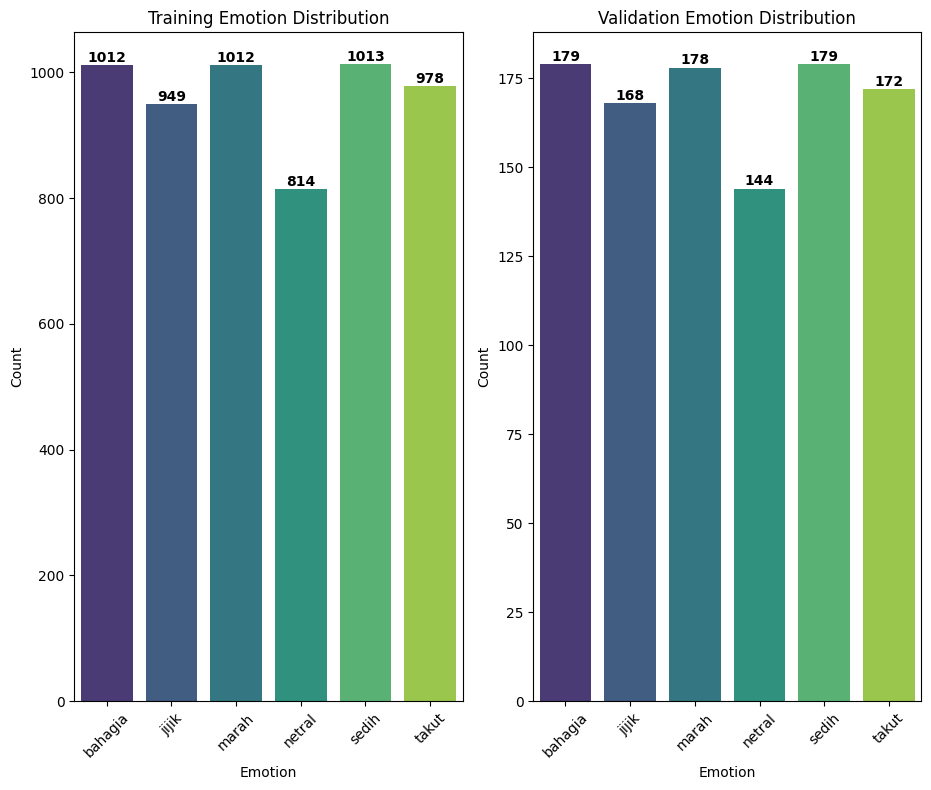

Emotion Distribution:

Training Dataset:
bahagia: 1012 samples (17.51%)
jijik: 949 samples (16.42%)
marah: 1012 samples (17.51%)
netral: 814 samples (14.09%)
sedih: 1013 samples (17.53%)
takut: 978 samples (16.93%)

Validation Dataset:
bahagia: 179 samples (17.55%)
jijik: 168 samples (16.47%)
marah: 178 samples (17.45%)
netral: 144 samples (14.12%)
sedih: 179 samples (17.55%)
takut: 172 samples (16.86%)


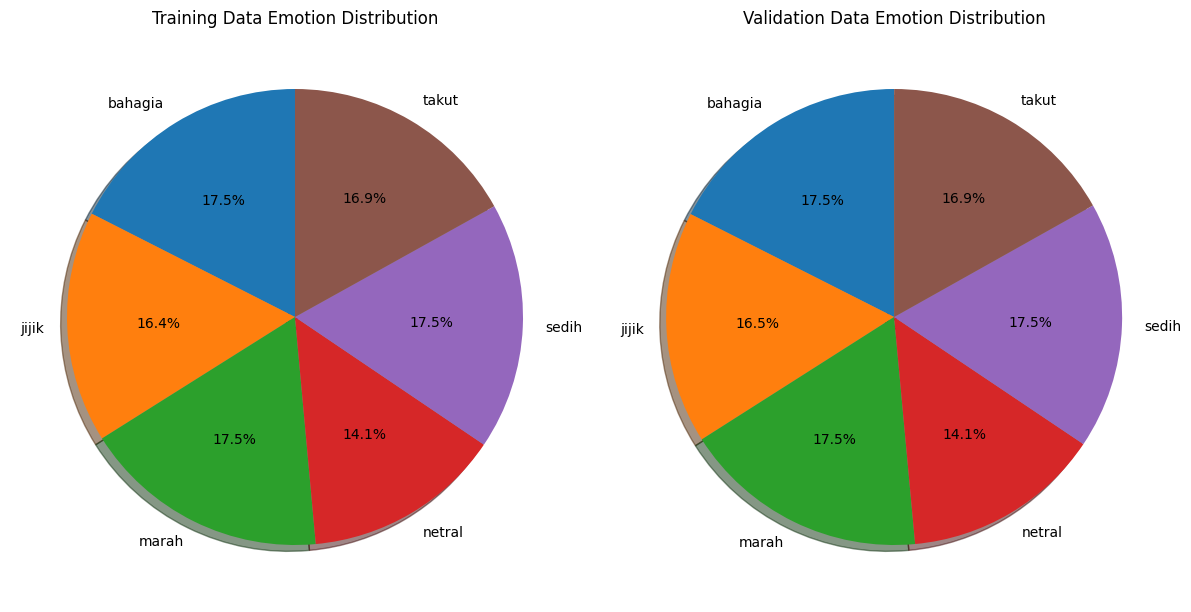


TRAINING CNN MODEL
Creating datasets...
Creating dataloaders...
Initializing CNN model...
✓ Input shape detected: torch.Size([16, 20, 64, 100])
✓ Using 20 input channels for the model
Model has 377,830 parameters (377,830 trainable)

Starting CNN model training...
Starting training loop...
Testing first batch load...
✓ First batch loaded successfully: torch.Size([16, 20, 64, 100])

Starting Epoch 1/10...
Training batches:
  Batch 10/362: loss=1.7977, acc=0.1875
  Batch 20/362: loss=1.8611, acc=0.2500
  Batch 30/362: loss=1.8706, acc=0.2500
  Batch 40/362: loss=1.7271, acc=0.2500
  Batch 50/362: loss=1.7843, acc=0.1875
  Batch 60/362: loss=1.7593, acc=0.2500
  Batch 70/362: loss=1.7264, acc=0.2500
  Batch 80/362: loss=1.6857, acc=0.2500
  Batch 90/362: loss=1.7511, acc=0.2500
  Batch 100/362: loss=1.7264, acc=0.1250
  Batch 110/362: loss=1.6780, acc=0.2500
  Batch 120/362: loss=1.6038, acc=0.2500
  Batch 130/362: loss=1.6455, acc=0.3125
  Batch 140/362: loss=1.6608, acc=0.3125
  Batch 

Predicting:   0%|          | 0/107 [00:00<?, ?it/s]

CNN predictions saved to cnn_submission.csv
Training history plot saved to cnn_history.png


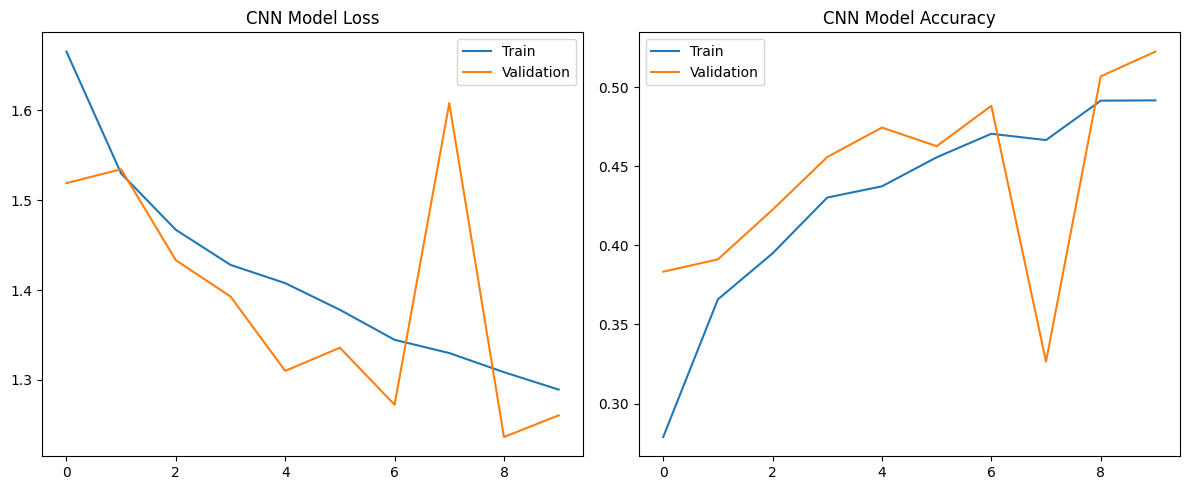


Best CNN Accuracy: 0.5225


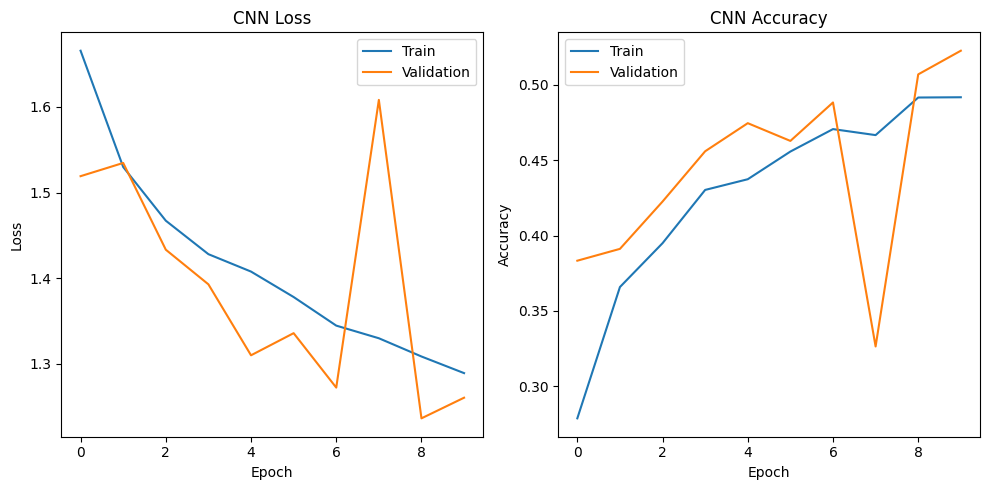

Speech Emotion Recognition with CNN completed successfully!
Results saved to cnn_submission.csv


In [8]:
# Run the main function with your choice of model
if __name__ == "__main__":
    # Change this to 'cnn', 'transformer', or 'wav2vec2'
    selected_model = 'cnn'
    main(selected_model)

Loading data...
Training data shape: (6798, 2)
Test data shape: (1700, 1)
Training data: 5778 samples
Validation data: 1020 samples
Test data: 1700 samples
Analyzing data distribution...


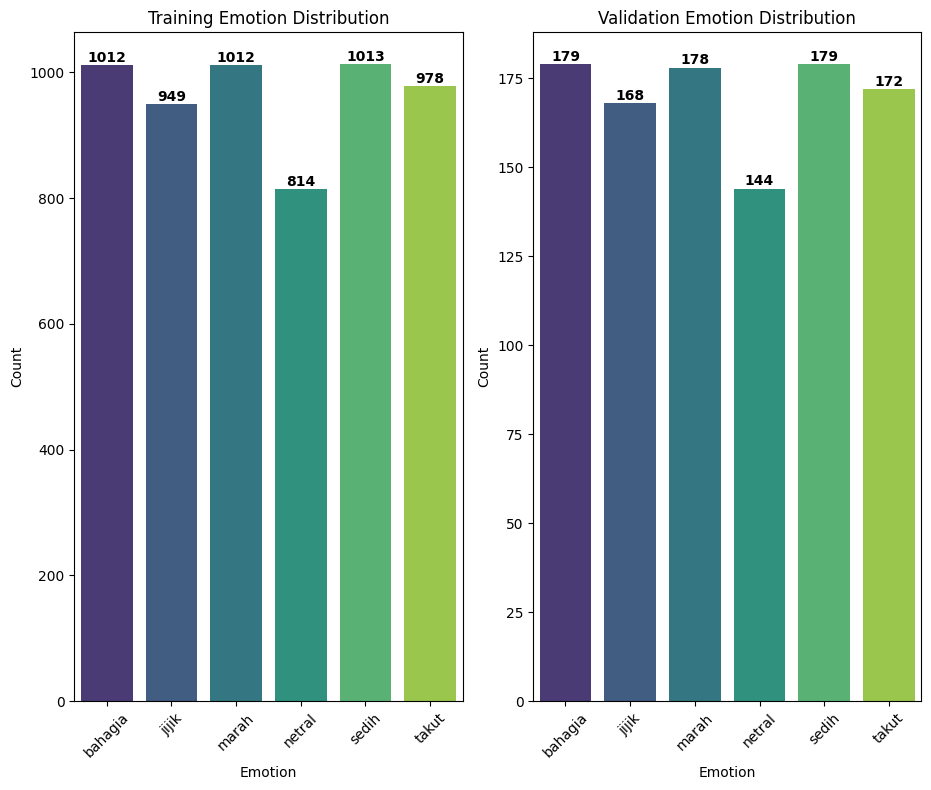

Emotion Distribution:

Training Dataset:
bahagia: 1012 samples (17.51%)
jijik: 949 samples (16.42%)
marah: 1012 samples (17.51%)
netral: 814 samples (14.09%)
sedih: 1013 samples (17.53%)
takut: 978 samples (16.93%)

Validation Dataset:
bahagia: 179 samples (17.55%)
jijik: 168 samples (16.47%)
marah: 178 samples (17.45%)
netral: 144 samples (14.12%)
sedih: 179 samples (17.55%)
takut: 172 samples (16.86%)


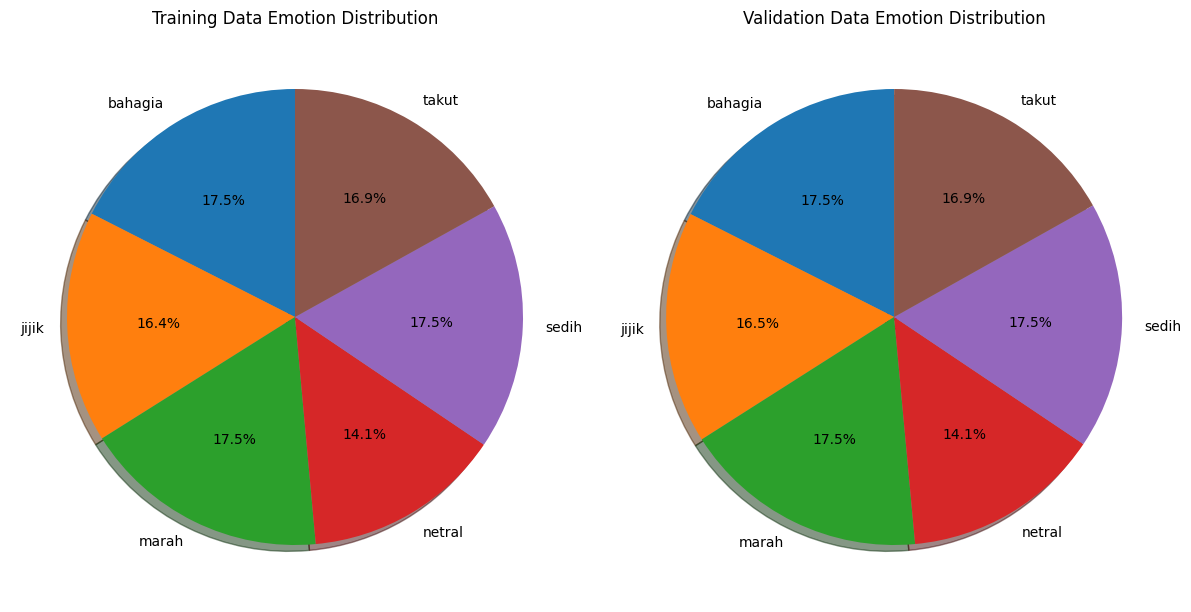


TRAINING TRANSFORMER MODEL
Creating datasets...
Creating dataloaders...
Initializing transformer model...
✓ Input shape detected: torch.Size([16, 20, 64, 100])
Model has 675,751 parameters (675,751 trainable)

Starting transformer model training...
Starting training loop...
Testing first batch load...
✓ First batch loaded successfully: torch.Size([16, 20, 64, 100])

Starting Epoch 1/15...
Training batches:
  Batch 10/362: loss=1.6941, acc=0.1875
  Batch 20/362: loss=1.7217, acc=0.4375
  Batch 30/362: loss=1.7716, acc=0.2500
  Batch 40/362: loss=1.7322, acc=0.0625
  Batch 50/362: loss=1.6111, acc=0.3125
  Batch 60/362: loss=1.5324, acc=0.5000
  Batch 70/362: loss=1.7834, acc=0.1875
  Batch 80/362: loss=1.5881, acc=0.5625
  Batch 90/362: loss=1.7739, acc=0.1875
  Batch 100/362: loss=1.5045, acc=0.5000
  Batch 110/362: loss=1.6372, acc=0.3125
  Batch 120/362: loss=1.8011, acc=0.1875
  Batch 130/362: loss=1.4498, acc=0.5000
  Batch 140/362: loss=2.0929, acc=0.1250
  Batch 150/362: loss=1.

Predicting:   0%|          | 0/107 [00:00<?, ?it/s]

Transformer predictions saved to transformer_submission.csv
Training history plot saved to transformer_history.png


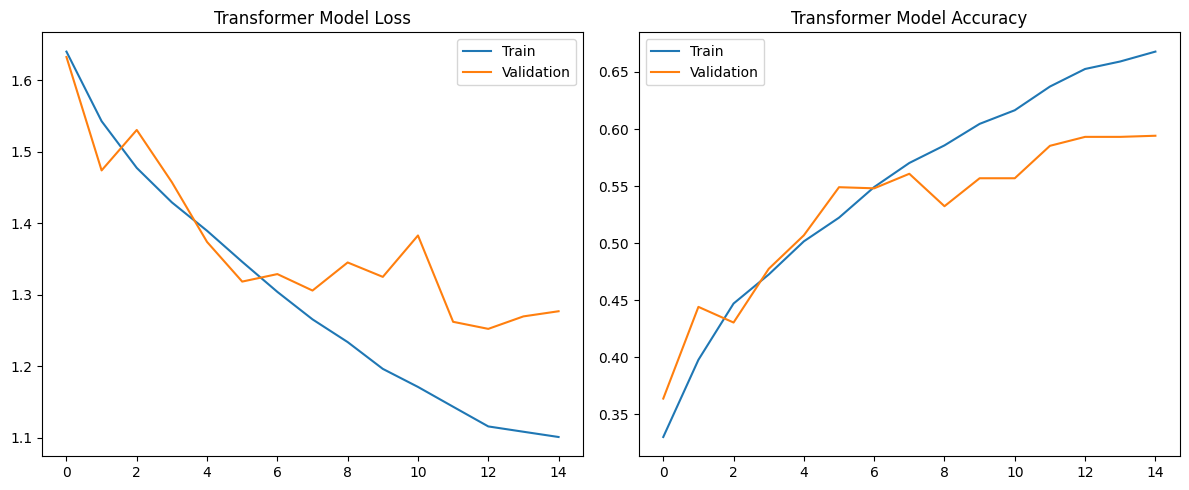


Best Transformer Accuracy: 0.5941


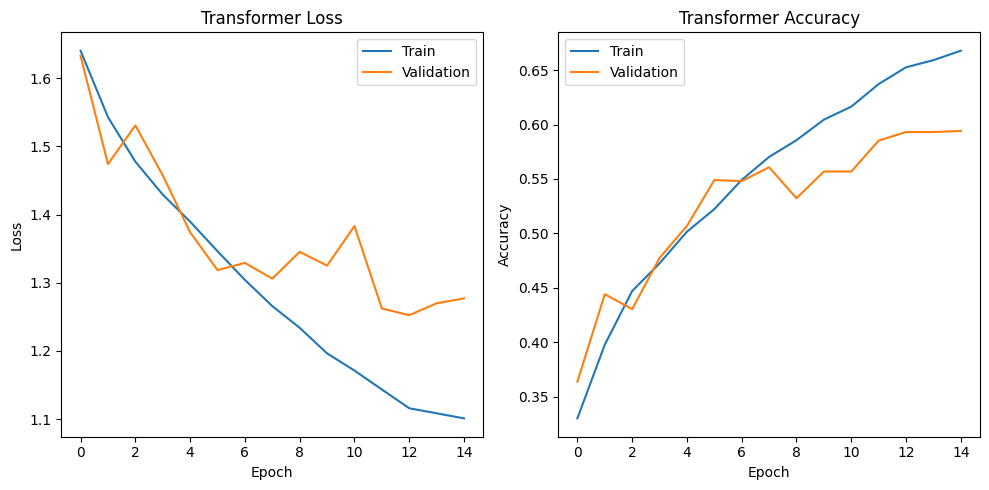

Speech Emotion Recognition with Transformer completed successfully!
Results saved to transformer_submission.csv


In [9]:
# Run the main function with your choice of model
if __name__ == "__main__":
    # Change this to 'cnn', 'transformer', or 'wav2vec2'
    selected_model = 'transformer'
    main(selected_model)

Loading data...
Training data shape: (6798, 2)
Test data shape: (1700, 1)
Training data: 5778 samples
Validation data: 1020 samples
Test data: 1700 samples
Analyzing data distribution...


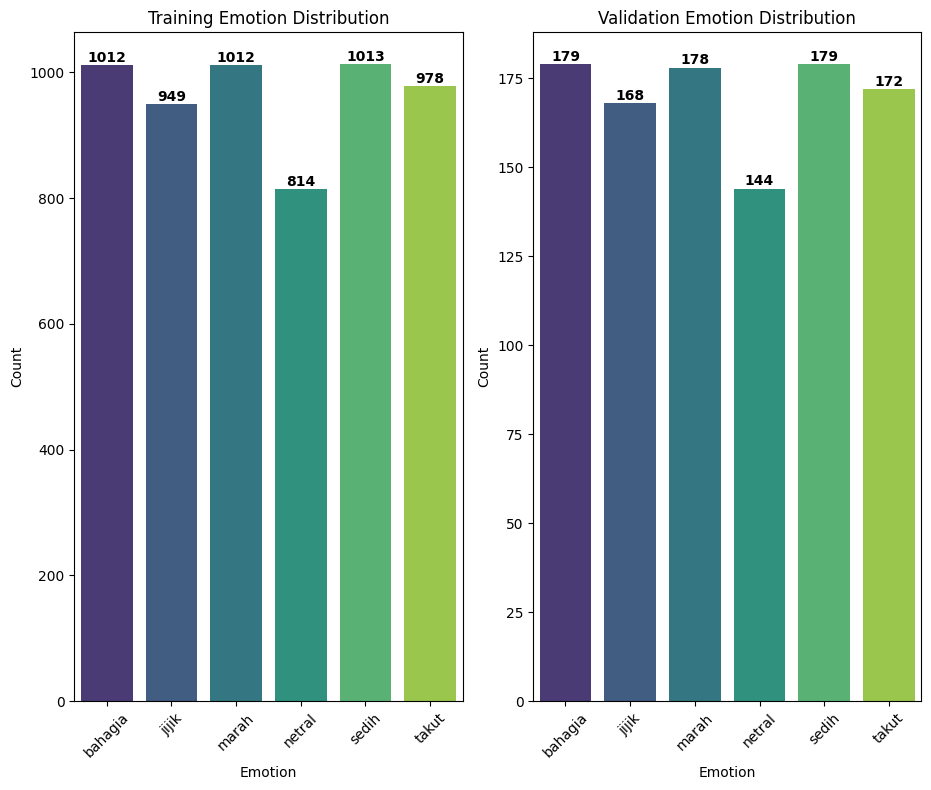

Emotion Distribution:

Training Dataset:
bahagia: 1012 samples (17.51%)
jijik: 949 samples (16.42%)
marah: 1012 samples (17.51%)
netral: 814 samples (14.09%)
sedih: 1013 samples (17.53%)
takut: 978 samples (16.93%)

Validation Dataset:
bahagia: 179 samples (17.55%)
jijik: 168 samples (16.47%)
marah: 178 samples (17.45%)
netral: 144 samples (14.12%)
sedih: 179 samples (17.55%)
takut: 172 samples (16.86%)


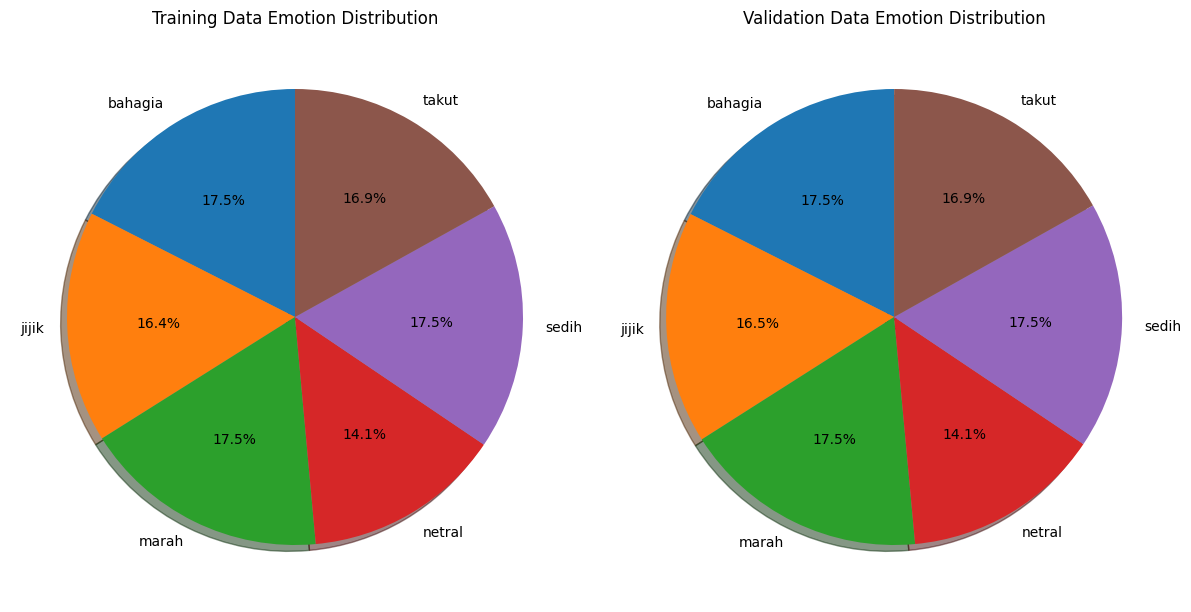


TRAINING OPTIMIZED WAV2VEC2 MODEL
Creating optimized raw audio datasets...
Initializing optimized Wav2Vec2 model with multiple unfrozen layers...
Wav2Vec2 model has 12 transformer layers
Unfreezing the last 3 transformer layers
Unfreezing layer 11
Unfreezing layer 10
Unfreezing layer 9
Model has 94,701,575 parameters (21,593,479 trainable)

Starting enhanced Wav2Vec2 training for 6 epochs...
Starting accelerated training...

Starting Epoch 1/6...


Training epoch 1:   0%|          | 0/362 [00:00<?, ?it/s]

  Batch 50/362: loss=1.6898
  Batch 100/362: loss=1.6208
  Batch 150/362: loss=1.4810
  Batch 200/362: loss=1.6262
  Batch 250/362: loss=1.3563
  Batch 300/362: loss=1.4383
  Batch 350/362: loss=0.8976

Evaluating epoch 1...


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/6 Summary:
  Train Loss: 1.4357, Train Acc: 0.4763
  Val Loss: 1.2661, Val Acc: 0.5804
  ✓ New best model saved with accuracy: 0.5804

Starting Epoch 2/6...


Training epoch 2:   0%|          | 0/362 [00:00<?, ?it/s]

  Batch 50/362: loss=0.8680
  Batch 100/362: loss=0.8671
  Batch 150/362: loss=1.0306
  Batch 200/362: loss=1.3509
  Batch 250/362: loss=1.0388
  Batch 300/362: loss=1.3118
  Batch 350/362: loss=1.1354

Evaluating epoch 2...


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/6 Summary:
  Train Loss: 1.1669, Train Acc: 0.6338
  Val Loss: 1.2105, Val Acc: 0.6225
  ✓ New best model saved with accuracy: 0.6225

Starting Epoch 3/6...


Training epoch 3:   0%|          | 0/362 [00:00<?, ?it/s]

  Batch 50/362: loss=0.8961
  Batch 100/362: loss=1.1702
  Batch 150/362: loss=1.0981
  Batch 200/362: loss=0.9092
  Batch 250/362: loss=1.0199
  Batch 300/362: loss=1.1518
  Batch 350/362: loss=0.9509

Evaluating epoch 3...


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/6 Summary:
  Train Loss: 1.0412, Train Acc: 0.7023
  Val Loss: 1.0933, Val Acc: 0.6696
  ✓ New best model saved with accuracy: 0.6696

Starting Epoch 4/6...


Training epoch 4:   0%|          | 0/362 [00:00<?, ?it/s]

  Batch 50/362: loss=0.7594
  Batch 100/362: loss=1.1309
  Batch 150/362: loss=0.9254
  Batch 200/362: loss=0.9090
  Batch 250/362: loss=1.4621
  Batch 300/362: loss=1.0188
  Batch 350/362: loss=0.7691

Evaluating epoch 4...


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/6 Summary:
  Train Loss: 0.9541, Train Acc: 0.7442
  Val Loss: 1.0369, Val Acc: 0.7049
  ✓ New best model saved with accuracy: 0.7049

Starting Epoch 5/6...


Training epoch 5:   0%|          | 0/362 [00:00<?, ?it/s]

  Batch 50/362: loss=0.7476
  Batch 100/362: loss=0.8084
  Batch 150/362: loss=1.0950
  Batch 200/362: loss=1.1904
  Batch 250/362: loss=0.9768
  Batch 300/362: loss=0.9860
  Batch 350/362: loss=0.6297

Evaluating epoch 5...


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/6 Summary:
  Train Loss: 0.8969, Train Acc: 0.7748
  Val Loss: 0.9915, Val Acc: 0.7333
  ✓ New best model saved with accuracy: 0.7333

Starting Epoch 6/6...


Training epoch 6:   0%|          | 0/362 [00:00<?, ?it/s]

  Batch 50/362: loss=0.9612
  Batch 100/362: loss=0.8226
  Batch 150/362: loss=0.7137
  Batch 200/362: loss=0.5978
  Batch 250/362: loss=0.8995
  Batch 300/362: loss=0.7361
  Batch 350/362: loss=0.8879

Evaluating epoch 6...


Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/6 Summary:
  Train Loss: 0.8431, Train Acc: 0.8006
  Val Loss: 0.9758, Val Acc: 0.7461
  ✓ New best model saved with accuracy: 0.7461
Loaded best model

Generating predictions with optimized Wav2Vec2 model...


Predicting:   0%|          | 0/107 [00:00<?, ?it/s]

Wav2Vec2 predictions saved to wav2vec_submission.csv
Training history plot saved to wav2vec_history.png


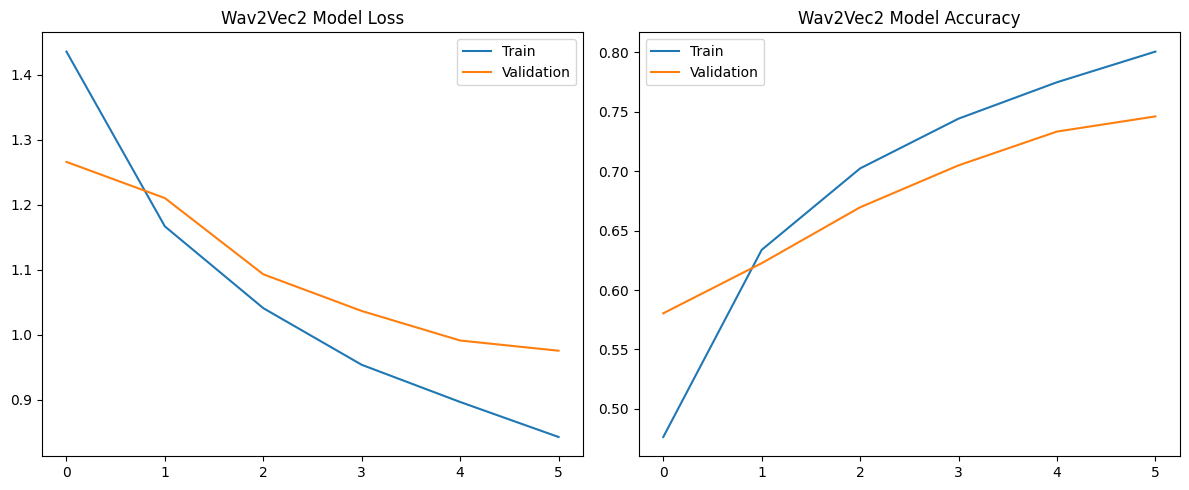


Best Optimized Wav2Vec2 Accuracy: 0.7461


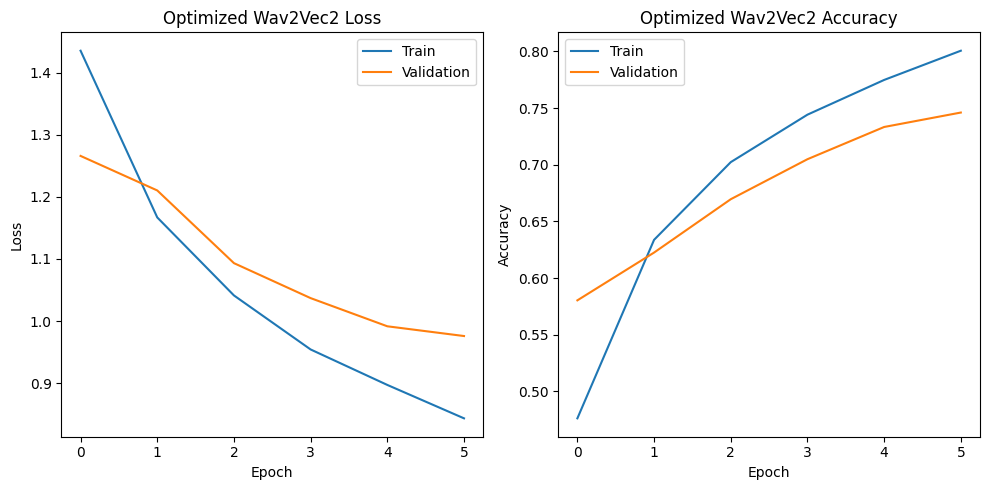

Speech Emotion Recognition with Optimized Wav2Vec2 completed successfully!
Results saved to wav2vec_optimized_submission.csv


In [8]:
# Run the main function with your choice of model
if __name__ == "__main__":
    # Change this to 'cnn', 'transformer', or 'wav2vec2'
    selected_model = 'wav2vec2'
    main(selected_model)

Wav2Vec2 model has 12 transformer layers
Unfreezing the last 3 transformer layers
Unfreezing layer 11
Unfreezing layer 10
Unfreezing layer 9
Loaded wav2vec2 model from checkpoints/best_wav2vec.pth

Selected Training Files:
- 1_01198_sedih_no_data.wav
- 1_00337_jijik_rendah.wav
- 1_01430_bahagia_no_data.wav
- 1_00321_marah_no_data.wav
- 1_07112_netral_no_data.wav

Selected Test Files:
- test987.wav
- test1395.wav
- test364.wav
- test730.wav
- test529.wav

Processing training files...

Training File Inference Results:
File: 1_01198_sedih_no_data.wav -> Emotion: sedih (Confidence: 0.81)
File: 1_00337_jijik_rendah.wav -> Emotion: jijik (Confidence: 0.86)
File: 1_01430_bahagia_no_data.wav -> Emotion: bahagia (Confidence: 0.88)
File: 1_00321_marah_no_data.wav -> Emotion: marah (Confidence: 0.93)
File: 1_07112_netral_no_data.wav -> Emotion: netral (Confidence: 0.83)

Processing test files...

Test File Inference Results:
File: test987.wav -> Emotion: takut (Confidence: 0.57)
File: test1395.wa

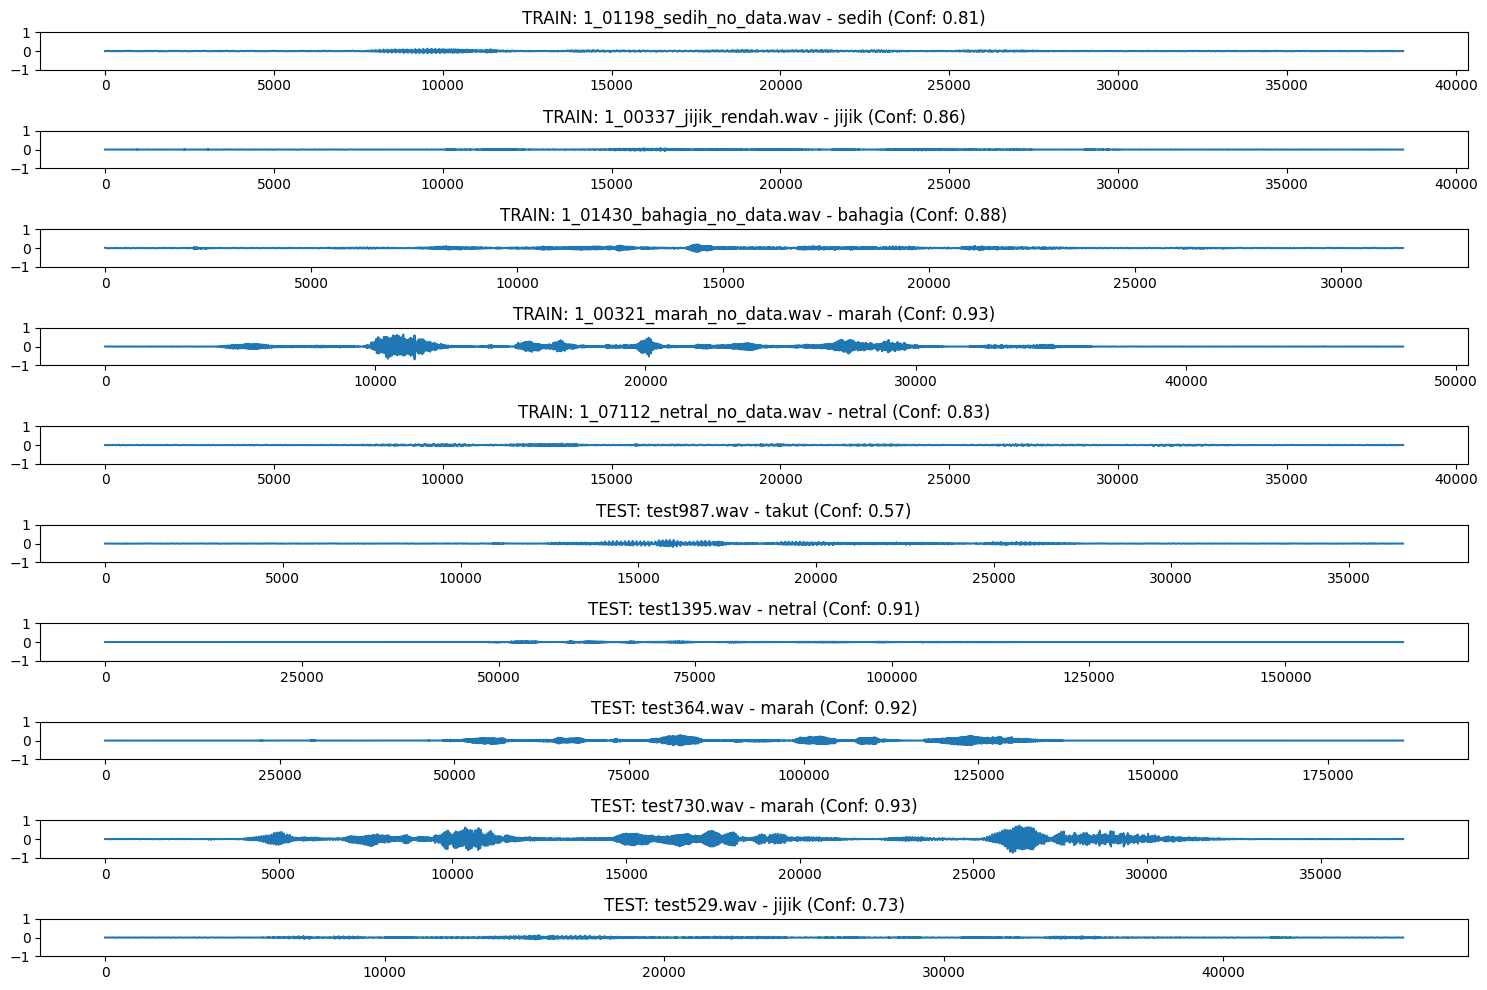

In [14]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader

# Function to load a saved model (unchanged)
def load_model(model_type, model_path):
    if model_type == 'cnn':
        model = LightEmotionCNN(num_classes=6, in_channels=20)
    elif model_type == 'transformer':
        model = EmotionTransformer(num_classes=6, in_channels=20)
    elif model_type == 'wav2vec2':
        model = Wav2Vec2ForSEROptimized(num_classes=6)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Move model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    print(f"Loaded {model_type} model from {model_path}")
    return model, device

# Inference function with better path handling
def infer_emotion(model, model_type, audio_paths, base_dir=""):
    reverse_mapping = {0: "marah", 1: "jijik", 2: "takut", 3: "bahagia", 4: "netral", 5: "sedih"}
    device = next(model.parameters()).device
    
    # Create a DataFrame with just the filenames, not full paths
    file_ids = [os.path.basename(path) for path in audio_paths]
    
    # For both datasets, use the provided base directory
    if model_type in ['cnn', 'transformer']:
        example_dataset = EmotionDataset(
            pd.DataFrame({'id': file_ids}), 
            base_path=base_dir,
            fast_mode=True
        )
    else:  # wav2vec2
        example_dataset = FastRawAudioEmotionDataset(
            pd.DataFrame({'id': file_ids}),
            base_path=base_dir
        )
    
    example_loader = DataLoader(
        example_dataset, 
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    
    results = []
    probabilities = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in example_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            max_prob, preds = torch.max(probs, 1)
            emotion = reverse_mapping[preds.item()]
            results.append(emotion)
            probabilities.append(max_prob.item())
    
    return results, probabilities

# Example usage with better error handling
if __name__ == "__main__":
    # Choose your model type
    model_type = 'wav2vec2'  # Change to your desired model: 'cnn', 'transformer', or 'wav2vec2'
    
    # Path to saved model
    if model_type == 'wav2vec2':
        model_path = 'checkpoints/best_wav2vec.pth'
    else:
        model_path = 'checkpoints/best_model.pth'
    
    try:
        # Load the model
        model, device = load_model(model_type, model_path)
        
        # ===== LOAD 5 TRAINING FILES =====
        train_files = []
        try:
            train_df = pd.read_csv('train.csv')
            if 'label' in train_df.columns:
                # Try to get diverse samples (one from each emotion)
                selected_files = []
                unique_emotions = train_df['label'].unique()
                for emotion in unique_emotions[:5]:  # Get up to 5 different emotions
                    sample = train_df[train_df['label'] == emotion].sample(1)
                    selected_files.append(f"{sample['id'].values[0]}")
                
                # If we didn't get 5 files, add more random ones
                if len(selected_files) < 5:
                    more_samples = train_df.sample(5 - len(selected_files))
                    for _, row in more_samples.iterrows():
                        selected_files.append(f"{row['id']}")
                
                # Make sure we have exactly 5 files
                train_files = selected_files[:5]
            else:
                # Just get random samples if no labels
                train_files = [f"{id}" for id in train_df.sample(5)['id'].values]
                
        except Exception as e:
            print(f"Error loading train files from CSV: {e}")
            try:
                train_files = glob('train/*.wav')[:5]
            except Exception:
                print("Could not find training files automatically.")
        
        # ===== LOAD 5 TEST FILES =====
        test_files = []
        try:
            test_df = pd.read_csv('test.csv')
            # Get 5 random samples
            test_files = [f"{id}" for id in test_df.sample(5)['id'].values]
        except Exception as e:
            print(f"Error loading test files from CSV: {e}")
            try:
                test_files = glob('test/*.wav')[:5]
            except Exception:
                print("Could not find test files automatically.")
        
        print(f"\nSelected Training Files:")
        for file in train_files:
            print(f"- {file}")
            
        print(f"\nSelected Test Files:")
        for file in test_files:
            print(f"- {file}")
        
        # Verify files exist and prepend directory
        valid_train_files = []
        for file in train_files:
            path = os.path.join("train", file)
            if os.path.exists(path):
                valid_train_files.append(file)
            else:
                print(f"Warning: Training file not found: {path}")
                
        valid_test_files = []
        for file in test_files:
            path = os.path.join("test", file)
            if os.path.exists(path):
                valid_test_files.append(file)
            else:
                print(f"Warning: Test file not found: {path}")
        
        if not valid_train_files and not valid_test_files:
            raise FileNotFoundError("No valid audio files found to process")
            
        # ===== INFERENCE ON TRAIN FILES =====
        train_emotions = []
        train_probs = []
        if valid_train_files:
            print("\nProcessing training files...")
            train_emotions, train_probs = infer_emotion(model, model_type, valid_train_files, "train")
            
            print("\nTraining File Inference Results:")
            for audio_file, emotion, prob in zip(valid_train_files, train_emotions, train_probs):
                print(f"File: {audio_file} -> Emotion: {emotion} (Confidence: {prob:.2f})")
        
        # ===== INFERENCE ON TEST FILES =====
        test_emotions = []
        test_probs = []
        if valid_test_files:
            print("\nProcessing test files...")
            test_emotions, test_probs = infer_emotion(model, model_type, valid_test_files, "test")
            
            print("\nTest File Inference Results:")
            for audio_file, emotion, prob in zip(valid_test_files, test_emotions, test_probs):
                print(f"File: {audio_file} -> Emotion: {emotion} (Confidence: {prob:.2f})")
        
        # ===== VISUALIZE WAVEFORMS =====
        # Create a figure with enough subplots for all files
        plt.figure(figsize=(15, 10))
        
        # Plot training files first
        for i, audio_file in enumerate(valid_train_files):
            try:
                audio_path = os.path.join("train", audio_file)
                waveform, sample_rate = torchaudio.load(audio_path)
                plt.subplot(len(valid_train_files) + len(valid_test_files), 1, i+1)
                plt.plot(waveform[0].numpy())
                plt.title(f"TRAIN: {audio_file} - {train_emotions[i]} (Conf: {train_probs[i]:.2f})")
                plt.ylim([-1, 1])  # Standardize y-axis
            except Exception as e:
                plt.subplot(len(valid_train_files) + len(valid_test_files), 1, i+1)
                plt.text(0.5, 0.5, f"Error loading audio: {str(e)}", 
                        horizontalalignment='center', verticalalignment='center')
                plt.axis('off')
        
        # Then plot test files
        offset = len(valid_train_files)
        for i, audio_file in enumerate(valid_test_files):
            try:
                audio_path = os.path.join("test", audio_file)
                waveform, sample_rate = torchaudio.load(audio_path)
                plt.subplot(len(valid_train_files) + len(valid_test_files), 1, offset+i+1)
                plt.plot(waveform[0].numpy())
                plt.title(f"TEST: {audio_file} - {test_emotions[i]} (Conf: {test_probs[i]:.2f})")
                plt.ylim([-1, 1])  # Standardize y-axis
            except Exception as e:
                plt.subplot(len(valid_train_files) + len(valid_test_files), 1, offset+i+1)
                plt.text(0.5, 0.5, f"Error loading audio: {str(e)}", 
                        horizontalalignment='center', verticalalignment='center')
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()